In [1]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
## Load and Transform our Data
# Orignal Data download from https://github.com/udacity/dermatologist-ai
data_dir = 'd:\\Data\\'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
valid_dir = os.path.join(data_dir, 'valid')

# classes are folders in each directory with these names
classes = ['melanoma', 'nevus', 'seborrheic_keratosis']

In [4]:
#Randowm Resize 
data_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(), 
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])])
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform) 
# print out some data stats
print('Num training images: ', len(train_data))
print('Num valid images: ', len(valid_data))
print('Num test images: ', len(test_data))

Num training images:  2000
Num valid images:  150
Num test images:  600


In [5]:
batch_size = 64
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

In [ ]:
# We should do data augmentation for samll datasize

In [6]:
def visual_data(data_loader,row_num,col_num):
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(row_num*col_num):
        ax = fig.add_subplot(col_num, row_num, idx+1, xticks=[], yticks=[])
        
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(classes[labels[idx]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

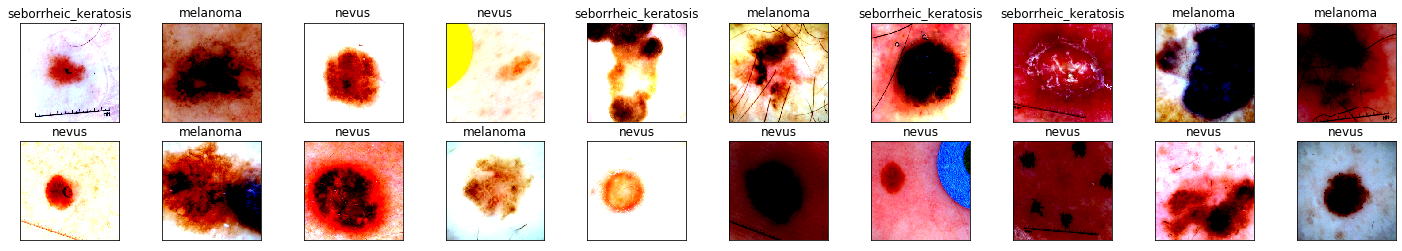

In [16]:
visual_data(train_loader,10,2)

In [7]:
resnet_50 = models.resnet50(pretrained=True)

#Freeze the parameters
for param in resnet_50.parameters():
    param.requires_grad_(False)
    
print(resnet_50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#for m in resnet_50.modules():
#    if isinstance(m, nn.Linear):
#        m.weight.data =  nn.init.xavier_uniform_(m.weight.data,gain=nn.init.calculate_gain('relu')) 

In [8]:
import torch.nn as nn
import torch.nn.functional as F

fc1 = nn.Linear(resnet_50.fc.in_features, 1024)
fc2 = nn.Linear(1024, 512)
fc3 = nn.Linear(512, 256)
fc4 = nn.Linear(256, 128)
fc5 = nn.Linear(128, len(classes))

fc_bn1 = nn.BatchNorm1d(1024)
fc_bn2 = nn.BatchNorm1d(512)
fc_bn3 = nn.BatchNorm1d(256)
fc_bn4 = nn.BatchNorm1d(128)
fc_bn5 = nn.BatchNorm1d(len(classes))                

fc1_drop = nn.Dropout(p=0.4)


In [9]:
#classfier = nn.Sequential(nn.Linear(25088, 2048, bias=True),
#                          nn.ReLU(),
#                          nn.Dropout(0.2),
#                          nn.Linear(2048,112),
#                          nn.ReLU()
#                         )

full_connected_layers = nn.Sequential(nn.Linear(resnet_50.fc.in_features, 1024),
                          nn.ReLU(),
                          nn.Dropout(0.2),
                          nn.Linear(1024, 512),
                          nn.ReLU(),
                          nn.Dropout(0.2),
                          nn.Linear(512, 256),
                          nn.ReLU(),
                          nn.Dropout(0.2),            
                          nn.Linear(256, 128),
                          nn.ReLU(),
                          nn.Dropout(0.2),            
                          nn.Linear(128, len(classes)) ) 

In [12]:
#full_connected_layers = nn.Sequential(nn.Linear(resnet_50.fc.in_features, 1024),
#                          nn.ReLU(nn.Linear(1024, 512)),
#                          nn.ReLU(nn.Linear(512, 256)),
#                          nn.ReLU(nn.Linear(256, 128)),
#                          nn.ReLU(nn.Linear(128, len(classes))) )

In [10]:
                
resnet_50.fc= full_connected_layers

# if GPU is available, move the model to GPU
if train_on_gpu:
    resnet_50.cuda()

print(resnet_50.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=256, out_features=128, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=128, out_features=3, bias=True)
)


In [41]:
print(resnet_50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
import torch.optim as optim
#Learning rate
lr = 0.0001
n_epochs = 20


# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.Adam(resnet_50.fc.parameters(), lr=0.001)


In [12]:
train_loss_list = list()
valid_loss_list = list()

#If train and valid_loss less than np.inf  save the valid_loss
#Or shall we do some linear combination train_loss_min and valid_loss_min? such as α*train_loss_min + β*valid_loss_min

train_loss_min = np.inf


model_dir = 'D:\\Data\\'
model_name = 'model_resnet_50.pt'
save_path = model_dir + model_name


In [13]:
resnet_50.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [14]:
def train_net(resnet_50,n_epochs, train_loss_list, valid_loss_list):
    valid_loss_min = np.inf
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        ######################    
        # Training the model #
        ###################### 
        resnet_50.train()
        train_loss = 0.0
        
        # train on batches of data, assumes you already have train_loader
        for batch_i, (data, target) in enumerate(train_loader):
            
            if train_on_gpu: 
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            
            output = resnet_50(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss = (train_loss * batch_i + loss.data) /  (batch_i + 1)
            train_loss_list.append(train_loss)
            print('Batch_i: {} \tTraining Loss: {:.6f} \t'.format(batch_i, train_loss,))
        ######################    
        # Valid the model #
        ###################### 
        resnet_50.eval()
        valid_loss = 0
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            
            output = resnet_50(data)
            loss = criterion(output, target)
            
            valid_loss = (valid_loss * batch_i + loss.data) /  (batch_i + 1)
            valid_loss_list.append(valid_loss)
        # print loss statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            valid_loss_min = valid_loss
            torch.save(resnet_50.state_dict(), save_path )

    print('Finished Training')


In [ ]:
#torch.autograd.set_detect_anomaly(True)
train_net(resnet_50,n_epochs,train_loss_list, valid_loss_list)

Batch_i: 0 	Training Loss: 0.506694 	
Batch_i: 1 	Training Loss: 0.680699 	
Batch_i: 2 	Training Loss: 0.603080 	
Batch_i: 3 	Training Loss: 0.605672 	
Batch_i: 4 	Training Loss: 0.595608 	
Batch_i: 5 	Training Loss: 0.584574 	
Batch_i: 6 	Training Loss: 0.603279 	
Batch_i: 7 	Training Loss: 0.583502 	
Batch_i: 8 	Training Loss: 0.588486 	
Batch_i: 9 	Training Loss: 0.577951 	
Batch_i: 10 	Training Loss: 0.616892 	
Batch_i: 11 	Training Loss: 0.604716 	
Batch_i: 12 	Training Loss: 0.608937 	
Batch_i: 13 	Training Loss: 0.608700 	
Batch_i: 14 	Training Loss: 0.604065 	
Batch_i: 15 	Training Loss: 0.604588 	
Batch_i: 16 	Training Loss: 0.603003 	
Batch_i: 17 	Training Loss: 0.607574 	
Batch_i: 18 	Training Loss: 0.605692 	
Batch_i: 19 	Training Loss: 0.596222 	
Batch_i: 20 	Training Loss: 0.604724 	
Batch_i: 21 	Training Loss: 0.602449 	
Batch_i: 22 	Training Loss: 0.599276 	
Batch_i: 23 	Training Loss: 0.605415 	
Batch_i: 24 	Training Loss: 0.603753 	
Batch_i: 25 	Training Loss: 0.60107

Batch_i: 11 	Training Loss: 0.522660 	
Batch_i: 12 	Training Loss: 0.525507 	
Batch_i: 13 	Training Loss: 0.531242 	
Batch_i: 14 	Training Loss: 0.532931 	
Batch_i: 15 	Training Loss: 0.539681 	
Batch_i: 16 	Training Loss: 0.539603 	
Batch_i: 17 	Training Loss: 0.544436 	
Batch_i: 18 	Training Loss: 0.545454 	
Batch_i: 19 	Training Loss: 0.537508 	
Batch_i: 20 	Training Loss: 0.535306 	
Batch_i: 21 	Training Loss: 0.556285 	
Batch_i: 22 	Training Loss: 0.556636 	
Batch_i: 23 	Training Loss: 0.553074 	
Batch_i: 24 	Training Loss: 0.549989 	
Batch_i: 25 	Training Loss: 0.554693 	
Batch_i: 26 	Training Loss: 0.555975 	
Batch_i: 27 	Training Loss: 0.554682 	
Batch_i: 28 	Training Loss: 0.555825 	
Batch_i: 29 	Training Loss: 0.558521 	
Batch_i: 30 	Training Loss: 0.564966 	
Batch_i: 31 	Training Loss: 0.565716 	
Epoch: 6 	Training Loss: 0.565716 	Validation Loss: 0.066123
Batch_i: 0 	Training Loss: 0.556854 	
Batch_i: 1 	Training Loss: 0.556234 	
Batch_i: 2 	Training Loss: 0.590712 	
Batch_

Batch_i: 22 	Training Loss: 0.499285 	
Batch_i: 23 	Training Loss: 0.499778 	
Batch_i: 24 	Training Loss: 0.498227 	
Batch_i: 25 	Training Loss: 0.496339 	
Batch_i: 26 	Training Loss: 0.492305 	
Batch_i: 27 	Training Loss: 0.492982 	
Batch_i: 28 	Training Loss: 0.490300 	
Batch_i: 29 	Training Loss: 0.490088 	
Batch_i: 30 	Training Loss: 0.494175 	
Batch_i: 31 	Training Loss: 0.490683 	
Epoch: 12 	Training Loss: 0.490683 	Validation Loss: 0.053918
Batch_i: 0 	Training Loss: 0.359295 	
Batch_i: 1 	Training Loss: 0.462305 	
Batch_i: 2 	Training Loss: 0.501666 	
Batch_i: 3 	Training Loss: 0.560144 	
Batch_i: 4 	Training Loss: 0.548851 	
Batch_i: 5 	Training Loss: 0.521411 	
Batch_i: 6 	Training Loss: 0.530260 	
Batch_i: 7 	Training Loss: 0.528537 	
Batch_i: 8 	Training Loss: 0.534239 	
Batch_i: 9 	Training Loss: 0.524150 	
Batch_i: 10 	Training Loss: 0.520492 	
Batch_i: 11 	Training Loss: 0.518237 	
Batch_i: 12 	Training Loss: 0.530590 	
Batch_i: 13 	Training Loss: 0.520028 	
Batch_i: 14 

Batch_i: 0 	Training Loss: 0.578662 	
Batch_i: 1 	Training Loss: 0.559482 	
Batch_i: 2 	Training Loss: 0.523466 	
Batch_i: 3 	Training Loss: 0.522175 	
Batch_i: 4 	Training Loss: 0.540260 	
Batch_i: 5 	Training Loss: 0.527807 	
Batch_i: 6 	Training Loss: 0.507169 	
Batch_i: 7 	Training Loss: 0.515027 	
Batch_i: 8 	Training Loss: 0.522649 	
Batch_i: 9 	Training Loss: 0.536486 	
Batch_i: 10 	Training Loss: 0.534409 	
Batch_i: 11 	Training Loss: 0.534107 	
Batch_i: 12 	Training Loss: 0.536265 	
Batch_i: 13 	Training Loss: 0.529890 	
Batch_i: 14 	Training Loss: 0.531097 	
Batch_i: 15 	Training Loss: 0.533720 	
Batch_i: 16 	Training Loss: 0.535946 	
Batch_i: 17 	Training Loss: 0.530021 	
Batch_i: 18 	Training Loss: 0.530265 	
Batch_i: 19 	Training Loss: 0.522470 	
Batch_i: 20 	Training Loss: 0.526920 	
Batch_i: 21 	Training Loss: 0.523403 	
Batch_i: 22 	Training Loss: 0.520753 	
Batch_i: 23 	Training Loss: 0.521087 	
Batch_i: 24 	Training Loss: 0.518706 	
